# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=73dd1711d6804fbe2b968cfd25d965cdfe3165543cd73df35b1560f5a40bf0fd
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=9d6a78cb95733bfe07bf34f5c14fad2d017131a996b9dbad00683ca346c0371c
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 17.34 MiB/s, done.
Resolving deltas: 100% (3/3), done.


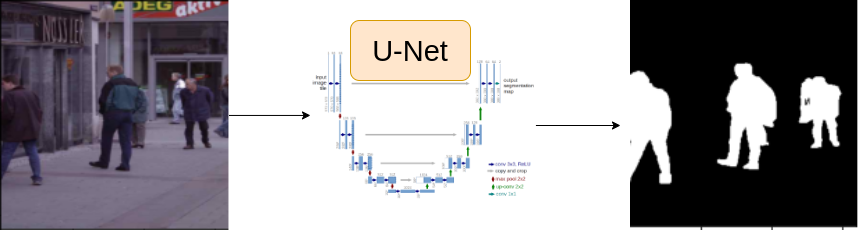

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [77]:
CSV_FILE = "/content/Human-Segmentation-Dataset-master/train.csv"
DATA_DIR = "/content/"

DEVICE = "cpu"
EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = "timm-efficientnet-b0"
WEIGHTS = "imagenet"

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(row.images)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0
print(mask)
print(type(mask))

(183, 276, 3)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
<class 'numpy.ndarray'>


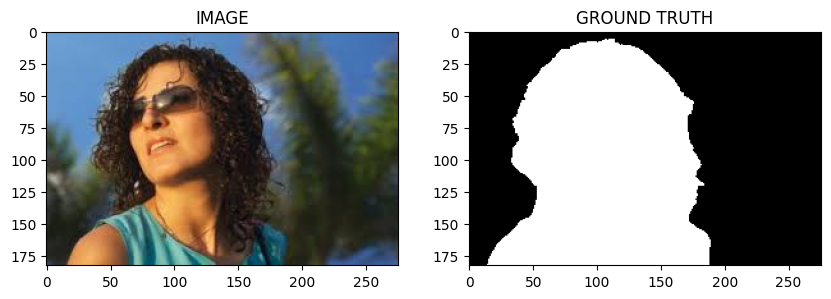

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

In [27]:
train_df.iloc[3].masks

'Human-Segmentation-Dataset-master/Ground_Truth/73.png'

In [33]:
train_df.loc[:,"masks"]

,masks
6,Human-Segmentation-Dataset-master/Ground_Truth...
209,Human-Segmentation-Dataset-master/Ground_Truth...
223,Human-Segmentation-Dataset-master/Ground_Truth...
261,Human-Segmentation-Dataset-master/Ground_Truth...
73,Human-Segmentation-Dataset-master/Ground_Truth...
...,...
188,Human-Segmentation-Dataset-master/Ground_Truth...
71,Human-Segmentation-Dataset-master/Ground_Truth...
106,Human-Segmentation-Dataset-master/Ground_Truth...
270,Human-Segmentation-Dataset-master/Ground_Truth...


# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5), #this will randomly flip the image horizontally with a probability of 0.5
      A.VerticalFlip(p = 0.5)
  ], is_check_shapes = False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ], is_check_shapes=False)

  #get_train_augs() and get_valid_augs() has is_check_shapes argument set to false as the augmentation pipeline already includes resize the images
  #image and masks dimension must match due to pixel-wise correspondence for masks and images

# Task 4 : Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [61]:
class SegmentationDataset(Dataset):
  '''
  According to the pytorch docs
  A custom Dataset class must implement three functions: __init__, __len__, and __getitem__.
  '''

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    # mask = np.expand_dims(mask, axis = -1)
    #np.expand_dims is depracated
    mask = np.reshape(mask, newshape=(mask.shape[0], mask.shape[1], 1))

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data["image"]
      mask = data["mask"]

    #(h,w,c) -> (c,h,w)

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [62]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [63]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


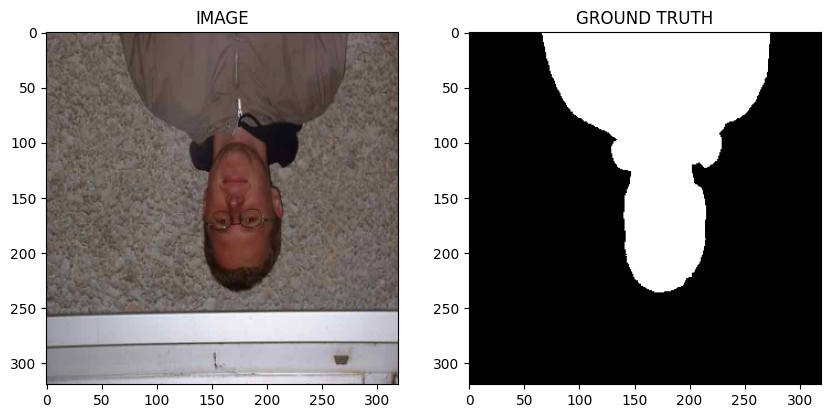

In [64]:
idx = 31
image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [65]:
from torch.utils.data import DataLoader

In [66]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [67]:
print(f'total no. of batches in trainloader : {len(trainloader)}')
print(f'total no. of batches in validloader : {len(validloader)}')

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [69]:
for image,mask in trainloader:
  break

print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [71]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [73]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights =  WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)
    #logit refers to the raw output of a model before any activation function is applied
    #logit is the input to the sigmoid function in log reg
    #self.arc is an instance of a model class that inherits from nn.Module which is callable
    #all classes taht inherit from nn.Module need to implement the forward method
    #since self.arc is callable, it will call the __call__(images)

    if masks != None:
      loss1 = DiceLoss(mode = "binary")(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [78]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function

In [79]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    #tqdm is used for the progress bar
    #i am transferring the batch of images and masks to the device to ensure computation is performed on the right device

    optimizer.zero_grad()
    logits, loss = model(images, masks)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(data_loader)


In [83]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss/len(data_loader)


# Task 8 : Train Model

In [84]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [86]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    print("SAVED-MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch : {i + 1} Train_loss : {train_loss} Valid_loss : {valid_loss}")


100%|██████████| 4/4 [00:14<00:00,  3.69s/it]


SAVED-MODEL
Epoch : 1 Train_loss : 0.30762163003285725 Valid_loss : 0.312458835542202


100%|██████████| 4/4 [00:15<00:00,  3.99s/it]


SAVED-MODEL
Epoch : 2 Train_loss : 0.2910880078872045 Valid_loss : 0.26797986403107643


100%|██████████| 4/4 [00:14<00:00,  3.67s/it]


SAVED-MODEL
Epoch : 3 Train_loss : 0.2835657874743144 Valid_loss : 0.26624031737446785


100%|██████████| 4/4 [00:18<00:00,  4.60s/it]


SAVED-MODEL
Epoch : 4 Train_loss : 0.21998245716094972 Valid_loss : 0.18694742023944855


100%|██████████| 4/4 [00:15<00:00,  3.91s/it]


Epoch : 5 Train_loss : 0.18061770101388294 Valid_loss : 0.19778595119714737


100%|██████████| 4/4 [00:18<00:00,  4.68s/it]


Epoch : 6 Train_loss : 0.1709587703148524 Valid_loss : 0.22188082337379456


100%|██████████| 4/4 [00:14<00:00,  3.67s/it]


Epoch : 7 Train_loss : 0.16075902730226516 Valid_loss : 0.27711155638098717


100%|██████████| 4/4 [00:15<00:00,  3.75s/it]


Epoch : 8 Train_loss : 0.19404934147993724 Valid_loss : 0.21977491676807404


100%|██████████| 4/4 [00:15<00:00,  3.88s/it]


Epoch : 9 Train_loss : 0.18032820175091427 Valid_loss : 0.20661348849534988


100%|██████████| 4/4 [00:14<00:00,  3.65s/it]


Epoch : 10 Train_loss : 0.14419250239928563 Valid_loss : 0.19639458879828453


100%|██████████| 4/4 [00:14<00:00,  3.73s/it]


Epoch : 11 Train_loss : 0.166665451725324 Valid_loss : 0.21968616172671318


100%|██████████| 4/4 [00:15<00:00,  3.76s/it]


Epoch : 12 Train_loss : 0.16727102051178613 Valid_loss : 0.24549534544348717


100%|██████████| 4/4 [00:14<00:00,  3.71s/it]


Epoch : 13 Train_loss : 0.13907678226629894 Valid_loss : 0.21399854868650436


100%|██████████| 4/4 [00:14<00:00,  3.74s/it]


SAVED-MODEL
Epoch : 14 Train_loss : 0.12395644088586172 Valid_loss : 0.17572187259793282


100%|██████████| 4/4 [00:15<00:00,  3.87s/it]


SAVED-MODEL
Epoch : 15 Train_loss : 0.11382222274939219 Valid_loss : 0.16615580022335052


100%|██████████| 4/4 [00:14<00:00,  3.67s/it]


Epoch : 16 Train_loss : 0.1242417797446251 Valid_loss : 0.23019637912511826


100%|██████████| 4/4 [00:15<00:00,  3.91s/it]


Epoch : 17 Train_loss : 0.12227398504813512 Valid_loss : 0.23081212863326073


100%|██████████| 4/4 [00:14<00:00,  3.73s/it]


Epoch : 18 Train_loss : 0.1253579303622246 Valid_loss : 0.20447134226560593


100%|██████████| 4/4 [00:15<00:00,  3.75s/it]


Epoch : 19 Train_loss : 0.12357016702493032 Valid_loss : 0.25623371452093124


100%|██████████| 4/4 [00:15<00:00,  3.87s/it]


Epoch : 20 Train_loss : 0.10408112357060115 Valid_loss : 0.21113215759396553


100%|██████████| 4/4 [00:14<00:00,  3.74s/it]


Epoch : 21 Train_loss : 0.10572922031084696 Valid_loss : 0.2521461993455887


100%|██████████| 4/4 [00:15<00:00,  3.87s/it]


Epoch : 22 Train_loss : 0.1192796841263771 Valid_loss : 0.2376548945903778


100%|██████████| 4/4 [00:14<00:00,  3.65s/it]


Epoch : 23 Train_loss : 0.10875537941853206 Valid_loss : 0.20326276868581772


100%|██████████| 4/4 [00:14<00:00,  3.63s/it]


Epoch : 24 Train_loss : 0.09958961804707846 Valid_loss : 0.20436377078294754


100%|██████████| 4/4 [00:14<00:00,  3.65s/it]

Epoch : 25 Train_loss : 0.0876947022974491 Valid_loss : 0.24544864520430565


# Task 9 : Inference

In [16]:
idx = 20

model.load_state_dict(torch.load("/content/best_model.pt"))

image, mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C, H, W) -> (1, C, H, W)
#moving the image tensor to the same device as the one for model for computation
#unsqueeze(0) adds a new dimension at the bgining of the tensor

pred_mask = torch.sigmoid(logits_mask)
#applies the sigmoid function on the output logits from the model
#values are between 0 and 1

pred_mask = (pred_mask > 0.5) * 1.0

In [16]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))